# Data Cleaning and Feature engineering

**References:**
- <https://www.projectpro.io/article/8-feature-engineering-techniques-for-machine-learning/423>

---

**Aim:**  
In this notebook we perform the cleaning of the dataset and some transformation of our data so that the dataset is suited to be used to train the a machine model.

# Exploratory question
**Main problem:** How different variables such as [odometer, year, condition, fuel, title_status, transmission, drive, state, brand] affect the resale price of a car.

**Subproblem 1**: How do different models (Tree regressor, linear regression, tree classifier) repond to the variables.  

**Subproblem 2**: Does applying feature engineering to the dataset change the way the model responds (Tree regressor, linear regression, tree classifier) to the dataest.  

**Subproblem 3**: Is there a better model (XGBoost) we can use to better predict the price of the car.  

In [1]:
## imports
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from IPython.display import Image, display_svg, SVG
sb.set() # set the default Seaborn style for graphics

In [2]:
carData = pd.read_csv('craigslist-carstrucks-data/vehicles.csv')
carData.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
# We use the code below to reduce memory usuage in our laptops
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

carData = reduce_mem_usage(carData)

Mem. usage decreased to 75.72 Mb (10.6% reduction)


We first check the correlation of numeric variables against price to determine the suitability of the training set. We will see that the correation is almost 0, indicating that there is a poor linear relationship. We proceed to look into some feature engineering to produce some results

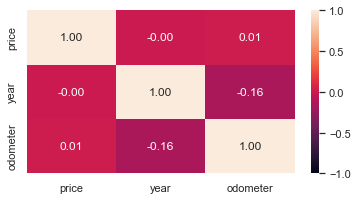

In [4]:
# Exploring the amount of data that we have to cleaning
# or fill to ensure we have a good test set
carData_clean=carData.copy()
(carData_clean.isnull().sum() * 100 / len(carData_clean))

# ---- Checking correlation of numeric variable ----
plt.figure(figsize=(6,3))
sb.heatmap(carData_clean[['price','year','odometer']].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")
plt.show()

## Data cleaning some research

- We went round looking on some [websites on cars](https://www.carandbike.com/news/most-expensive-cars-in-the-world-2701825) to have an idea of car pricing and we found that luxury cars normally start at 1 million

- Since we do not have have such brands in this dataset, we drop all prices above 1 million as we can see that these are mostly dirtied data and are used by car dealers to advertise themselves.

- We also see that all listings before 1920 are antiques and their prices are errorneous. We will drop them from the dataset as well. As for prices in 2022, we drop them from the dataset as we want to have the data for the full year.

In [5]:
#We can notice that there are 'dirty data' as the dataset is scraped from craigslist which does not validate 'realistic values', allowing for values such as $999,999,999 for price
#the highest priced car starts from $1million and most values above $1 million are mostly car dealerships looking for trades and are just advertisements
a = carData_clean.loc[~(carData_clean['price'] > 1000000)]
print("Shape before {}\nShape after {}\nPrice: Percentage of data lost: {}%".format(carData_clean.shape,\
                                           a.shape,\
                                           (carData_clean.shape[0]-a.shape[0])/carData_clean.shape[0] * 100))

#vintage era of cars start from 1920, data ver 10 scrapped on Aug 2021, any data in 2022 does not make sense
b = carData_clean.loc[~((carData_clean['year'] < 1920) | (carData_clean['year'].isnull()| (carData_clean['year'] > 2021)))]
print("Shape before {}\nShape after {}\nYear: Percentage of data lost: {}%".format(carData_clean.shape,\
                                           b.shape,\
                                           (carData_clean.shape[0]-b.shape[0])/carData_clean.shape[0] * 100))

carData_clean_dirty = carData_clean.loc[~((carData_clean['year'] < 1920) | (carData_clean['year'] > 2021) | (carData_clean['year'].isnull() | (carData_clean['price'] > 1000000)))]
print("Shape before {}\nShape after {}\nTotal: Percentage of data lost: {}%".format(carData_clean.shape,\
                                           carData_clean_dirty.shape,\
                                           (carData_clean.shape[0]-carData_clean_dirty.shape[0])/carData_clean.shape[0] * 100))

carData_clean = carData_clean_dirty.copy()
carData_clean.head(5)

Shape before (426880, 26)
Shape after (426827, 26)
Price: Percentage of data lost: 0.012415667166416792%
Shape before (426880, 26)
Shape after (425504, 26)
Year: Percentage of data lost: 0.32233883058470764%
Shape before (426880, 26)
Shape after (425452, 26)
Total: Percentage of data lost: 0.33452023988005997%


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
27,7316814884,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,...,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:18-0500
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.59375,-85.5,2021-05-03T14:02:03-0500


## Variable Transformations

Variable transformation techniques could help with normalizing skewed data. One such popularly used transformation is the **logarithmic transformation**.

Logarithmic transformations operate to compress the larger numbers and relatively expand the smaller numbers. This in turn results in less skewed values especially in the case of heavy-tailed distributions.

<AxesSubplot:xlabel='odometer', ylabel='Count'>

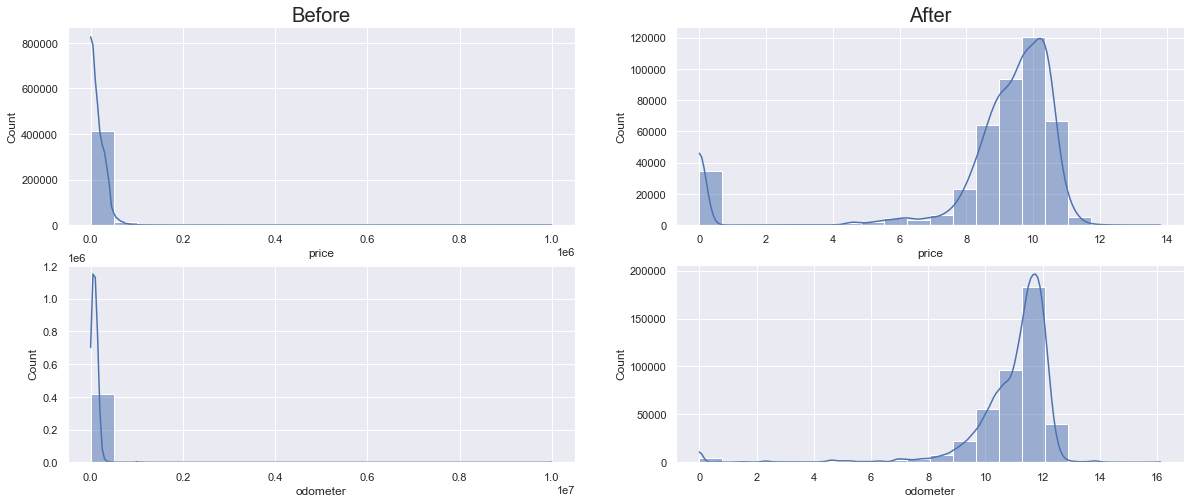

In [6]:
carData_clean_log = carData_clean.copy()

# Set all price < 1 to 1 so that log of that value will not
# be negative which could cause error in the fitting
carData_clean_log.loc[carData_clean_log['price'] < 1, ['price']] = 1.00000001
carData_clean_log['price'] = np.log(carData_clean_log['price'])

# Apply same logic to odometer as well
carData_clean_log.loc[carData_clean_log['odometer'] < 1, ['odometer']] = 1.00000001
carData_clean_log['odometer'] = np.log(carData_clean_log['odometer'])

# Visiualise the changes in the dataset before and after the 
# transformation. We can see that the data is now more like a normally
# distributed curve than before
f, axes = plt.subplots(2,2, figsize=(20, 8))
axes[0][0].set_title('Before', fontsize=20)
axes[0][1].set_title('After', fontsize=20)
sb.histplot(data = carData_clean, x = 'price', kde="True", bins = 20  ,ax = axes[0][0])
sb.histplot(data = carData_clean_log, x = 'price', kde="True", bins = 20, ax = axes[0][1])
sb.histplot(data = carData_clean, x = 'odometer', kde="True", bins = 20  ,ax = axes[1][0])
sb.histplot(data = carData_clean_log, x = 'odometer', kde="True", bins = 20, ax = axes[1][1])

## Handling Outliers

Outliers are unusually high or low values in the dataset which are unlikely to occur in normal scenarios. Since these outliers could adversely affect your prediction they must be handled appropriately.

Here we use the **boxplot logic of whiskers** to remove outliers in price and odometer.

Shape before (425452, 26)
Shape after (381426, 26)
Percentage of data lost: 10.348053364421839%


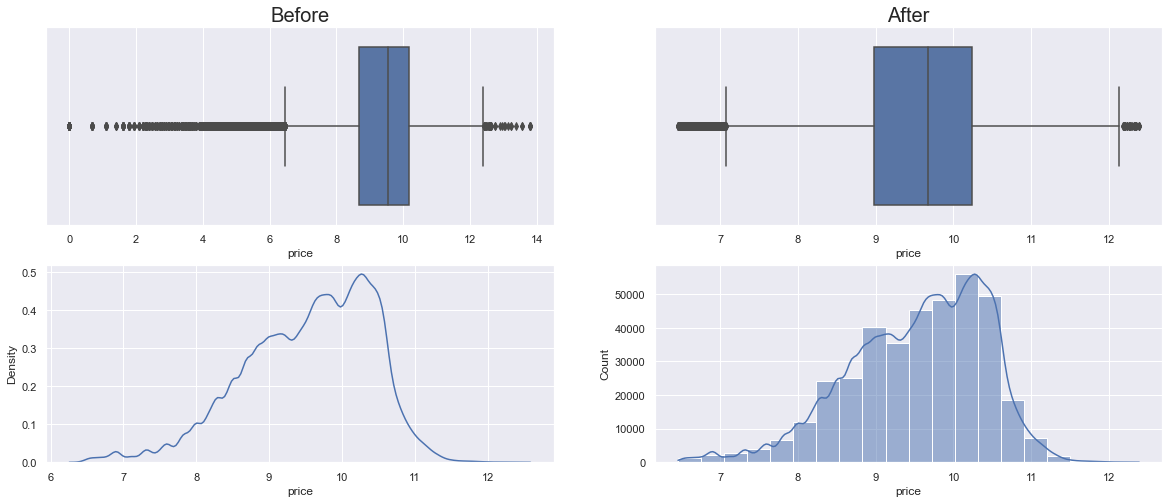

In [7]:
# Removing outliers outside of IQR whiskers based on price
def removeOutliers(item,df):
    Q1 = carData_clean_log[item].quantile(0.25)
    Q3 = carData_clean_log[item].quantile(0.75)
    IQR = Q3 - Q1
    carData_clean_log_IQR = df.loc[(df[item] > (Q1 - 1.5 * IQR)) & (df[item] < (Q3 + 1.5 * IQR))]
    carData_clean_log_IQR = carData_clean_log_IQR.reset_index(drop=True)
    return carData_clean_log_IQR


carData_clean_log_IQR=removeOutliers('price',carData_clean_log)

f, axes = plt.subplots(2,2, figsize=(20, 8))
axes[0][0].set_title('Before', fontsize=20)
axes[0][1].set_title('After', fontsize=20)
# boxplot of before and after removal of IQR outliers
sb.boxplot(data=carData_clean_log, x = 'price',ax=axes[0][0])
sb.boxplot(data=carData_clean_log_IQR, x = 'price',ax=axes[0][1])
print("Shape before {}\nShape after {}\nPercentage of data lost: {}%".format(carData_clean_log.shape,\
                                           carData_clean_log_IQR.shape,\
                                           (carData_clean_log.shape[0]-carData_clean_log_IQR.shape[0])/carData_clean_log.shape[0] * 100))

#new distribution
sb.kdeplot(data=carData_clean_log_IQR, x = 'price',ax=axes[1][0])
sb.histplot(data=carData_clean_log_IQR, x = 'price', kde="True", bins = 20, ax=axes[1][1])
plt.show()

Shape before (425452, 26)
Shape after (362227, 26)
Percentage of data lost: 14.860665833043447%


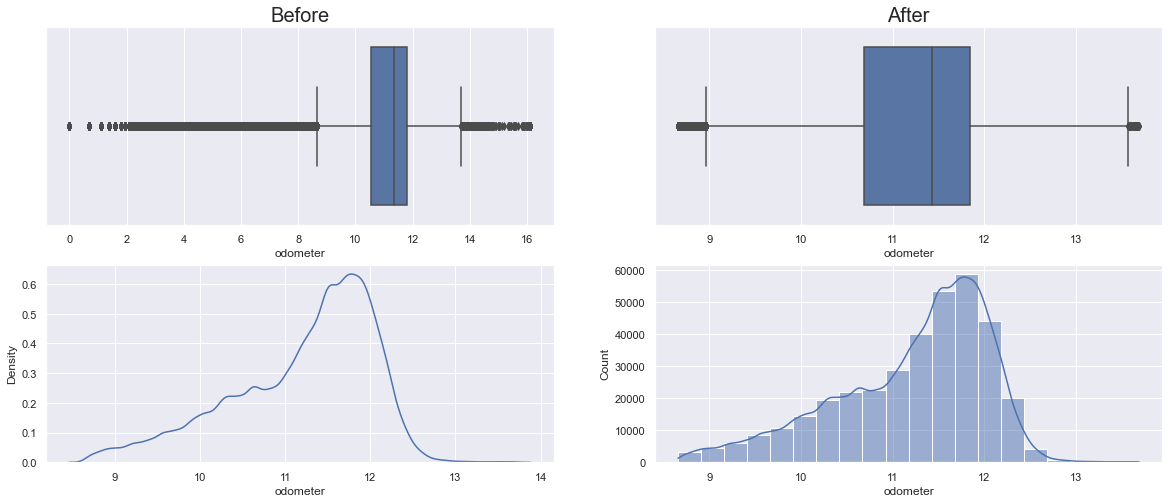

In [8]:
carData_clean_log_IQR=removeOutliers('odometer',carData_clean_log_IQR)

f, axes = plt.subplots(2,2, figsize=(20, 8))
axes[0][0].set_title('Before', fontsize=20)
axes[0][1].set_title('After', fontsize=20)
# boxplot of before and after removal of IQR outliers
sb.boxplot(data=carData_clean_log, x = 'odometer',ax=axes[0][0])
sb.boxplot(data=carData_clean_log_IQR, x = 'odometer',ax=axes[0][1])
print("Shape before {}\nShape after {}\nPercentage of data lost: {}%".format(carData_clean_log.shape,\
                                           carData_clean_log_IQR.shape,\
                                           (carData_clean_log.shape[0]-carData_clean_log_IQR.shape[0])/carData_clean_log.shape[0] * 100))

#new distribution
sb.kdeplot(data=carData_clean_log_IQR, x = 'odometer',ax=axes[1][0])
sb.histplot(data=carData_clean_log_IQR, x = 'odometer', kde="True", bins = 20, ax=axes[1][1])
plt.show()

In [9]:
carData_clean_log_IQR.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7316814884,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,10.421984,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,...,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:18-0500
1,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,10.025263,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:08-0500
2,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,10.586332,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T12:31:25-0500
3,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,10.341420,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.59375,-85.5,2021-05-04T10:41:31-0500
4,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,9.615805,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.59375,-85.5,2021-05-03T14:02:03-0500


## Dropping variables from the dataset
We see that there are a lot of columns that are not suitable due to the high NaN value rates in the column.

*Refer to EDA notebook for more information on this.*

In [10]:
carData_clean=carData_clean_log_IQR.copy()
# As discussed earlier, the columns that we are dropping here are not important
# in predicting the price of the car
# or have too many missing values that makes it undesirable
carData_clean.drop(columns=['id', 'url','region','region_url','model',\
                      'cylinders','size','type','paint_color',\
                      'image_url','description','county','lat',\
                      'long','posting_date','VIN'],
             inplace=True)
print(carData_clean.shape)
carData_unclean=carData_clean.copy()
carData_clean.head(5)

(362227, 10)


,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,drive,state
0,10.421984,2014.0,gmc,good,gas,10.966869,clean,other,NaN,al
1,10.025263,2010.0,chevrolet,good,gas,11.173656,clean,other,NaN,al
2,10.586332,2020.0,chevrolet,good,gas,9.860580,clean,other,NaN,al
3,10.341420,2017.0,toyota,good,gas,10.624347,clean,other,NaN,al
4,9.615805,2013.0,ford,excellent,gas,11.759786,clean,automatic,rwd,al


<AxesSubplot:>

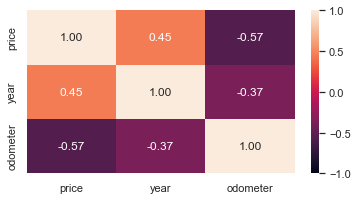

In [11]:
# ---- Checking correlation of numeric variable ----

# We now see that the correlation has improved significatly after applying
# data cleaning and feature engineering!
plt.figure(figsize=(6,3))
sb.heatmap(carData_clean[['price','year','odometer']].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

## Imputation

Imputation deals with handling missing values in data. Deleting records that are missing certain values is one way of dealing with this issue, but it could also mean losing out on a chunk of valuable data. This is where imputation can help.

We fill categorical type variables with a fixed value and numeric datatypes with the median

In [12]:
# ---- Here we create the clean dataset ----

# We want to fix the categorical columns but because each category has a unique meaning
# eg. condition has good, excellent, new etc, we cannot simply just fill a median in hopes
# that it will be filled correctly.

# We proceed to create a new label for each category called "NOTKNOWN" such that the value will not
# be NaN
# Filling missing values with constant 'NOTKNOWN'
carData_clean['drive'].fillna('NOTKNOWN',inplace=True)
carData_clean['condition'].fillna('NOTKNOWN',inplace=True)
carData_clean['fuel'].fillna('NOTKNOWN',inplace=True)
carData_clean['transmission'].fillna('NOTKNOWN',inplace=True)
carData_clean['title_status'].fillna('NOTKNOWN',inplace=True)
carData_clean.dropna(inplace=True, subset=['manufacturer'])

# We observe that the mean and median value of odometer is relatively close to each other
# we will go with filling in the 1% missing value of odometer with the median
carData_clean['odometer'].fillna(carData_clean['odometer'].median(),inplace=True)
carData_clean = carData_clean.reset_index(drop=True).copy()

# By filling with a constant, we avoid dropping the rows that contain data
# We then print out how percentage of missing col in the dataset
print("Shape of dataset is :",carData_clean.shape)
print("____________________________________________")
print("The percentage of missing values in the dataset is\nshown below:")
(carData_clean.isnull().sum() * 100 / len(carData_clean))

Shape of dataset is : (349614, 10)
____________________________________________
The percentage of missing values in the dataset is
shown below:


price           0.0
year            0.0
manufacturer    0.0
condition       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
state           0.0
dtype: float64

## Categorical Encoding

Categorical encoding is the technique used to encode categorical features into numerical values which are usually simpler for an algorithm to understand. One hot encoding(OHE)  is a popularly used technique of categorical encoding. Here, categorical values are converted into simple numerical 1’s and 0’s without the loss of information. As with other techniques, OHE has its own disadvantages and has to be used sparingly. It could result in a dramatic increase in the number of features and result in the creation of highly correlated features. 

In [13]:
# https://geoffruddock.com/one-hot-encoding-plus-linear-regression-equals-multi-collinearity/
# Need to produce  K-1 columns to prevent skewed coefficients for linear regression

# ---- One Hotencoding ----
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Others & missing values are equivalent to NOTKNOWN
carData_clean.loc[carData_clean['title_status'] == 'missing', ['title_status']] = 'NOTKNOWN'

## TODO, explain why we dont combine "others" into NOTKNOWN also
oneHotCategories = ["fuel", "title_status", "transmission", "drive"]

#OHE with drop first to get K-1 columns (prevent the dummy variable trap)
encoder = OneHotEncoder(drop='first', sparse=False)

#transforming the data into one-hot and concatenating it back into the original dataframe
transformed = encoder.fit_transform(carData_clean[oneHotCategories])
transformed_df = pd.DataFrame(transformed, columns=encoder.get_feature_names(oneHotCategories))
carData_clean = pd.concat([carData_clean.drop(oneHotCategories, axis = 1),transformed_df], axis=1)
carData_clean.head()

,price,year,manufacturer,condition,odometer,state,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,...,title_status_lien,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_NOTKNOWN,drive_fwd,drive_rwd
0,10.421984,2014.0,gmc,good,10.966869,al,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,10.025263,2010.0,chevrolet,good,11.173656,al,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,10.586332,2020.0,chevrolet,good,9.860580,al,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,10.341420,2017.0,toyota,good,10.624347,al,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,9.615805,2013.0,ford,excellent,11.759786,al,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Discretization

Discretization involves essentially taking a set of values of data and grouping sets of them together in some logical fashion into bins (or buckets). Binning can apply to numerical values as well as to categorical values. This could help prevent data from overfitting but comes at the cost of loss of granularity of data.

We apply discretization on the price category so that we can test if the transformation of price to categorical type data will help in improving the model fit and accuracy.

In [14]:
# ---- Making numerical data catergorical ----

# We group the range of prices into a price category.
# We define the category to be based on the quartile of the price
# this to ensure that we do not have too many numerical values to consider in the tree
# but we can transform the data into a categorical one
bins=list(carData_clean['price'].quantile(np.linspace(0.0, 0.9, num=10)))
names= [str(i) for i in range(1,11)]
d = dict(enumerate(names, 1))
carData_clean['PRICECATEGORY'] = np.vectorize(d.get)(np.digitize(carData_clean['price'], bins))

# ---- Application of label encoding ----

# We do label encoding for [state, manufacturer] because there are over 30 data unique points
# and to use them as onehot would cause our model to have too many variables to be 
# optimised with
# condition we can enforce an ordinal rankning.
from sklearn.preprocessing import LabelEncoder
categorial = ["condition","state","manufacturer"]

labelencoder = LabelEncoder()
for col in categorial:
    if col in carData_clean.columns:
        labelencoder.fit(list(carData_clean[col].astype(str).values))
        carData_clean[col] = labelencoder.transform(list(carData_clean[col].astype(str).values))

carData_clean.head(5)

,price,year,manufacturer,condition,odometer,state,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,...,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_NOTKNOWN,drive_fwd,drive_rwd,PRICECATEGORY
0,10.421984,2014.0,14,3,10.966869,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9
1,10.025263,2010.0,7,3,11.173656,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7
2,10.586332,2020.0,7,3,9.860580,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,10
3,10.341420,2017.0,39,3,10.624347,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9
4,9.615805,2013.0,13,1,11.759786,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5


In [15]:
print("The number of variables previously was: ",len(carData_unclean.columns))

print("The number of variables now is        : ",len(carData_clean.columns))

The number of variables previously was:  10
The number of variables now is        :  23


In [16]:
print("Shape of dataset was :",carData_unclean.shape)
print("____________________________________________")
print("The percentage of missing values in the dataset was:")
print(carData_unclean.isnull().sum() * 100 / len(carData_unclean))
print()
print("Shape of dataset is :",carData_clean.shape)
print("____________________________________________")
print("The percentage of missing values in the dataset was:")
print(carData_clean.isnull().sum() * 100 / len(carData_clean))

Shape of dataset was : (362227, 10)
____________________________________________
The percentage of missing values in the dataset was:
price            0.000000
year             0.000000
manufacturer     3.482071
condition       37.818274
fuel             0.561250
odometer         0.000000
title_status     1.602034
transmission     0.388707
drive           29.967120
state            0.000000
dtype: float64

Shape of dataset is : (349614, 23)
____________________________________________
The percentage of missing values in the dataset was:
price                      0.0
year                       0.0
manufacturer               0.0
condition                  0.0
odometer                   0.0
state                      0.0
fuel_diesel                0.0
fuel_electric              0.0
fuel_gas                   0.0
fuel_hybrid                0.0
fuel_other                 0.0
title_status_clean         0.0
title_status_lien          0.0
title_status_parts only    0.0
title_status_rebuilt   

In [17]:
carData_clean.to_csv('craigslist-carstrucks-data/carData_clean.csv', index=False)  

# End of data cleaning

This marks the end of this notebook.

To conlude, we did 

- Feature exploration with this notebook
     - imputation
     - discretization
     - categorical encoding
     - feature splitting
     - removing outliers
     - transformations
     - scaling

- Cleaned the dataset
- Saved the dataset as a csv file which we will use to analyse different models with.

Learning points

- Data available on kaggle is not always ideal an pre-processing is needed

- Different feature engineering techniques we can apply to a dataset to make the data more symmetrical